# San Francisco Crime Classification

San Franscisco is the cultural, commercail and financial center of Northern California. It's city with almost 900,000 residents (2019). San Francisco has the highest salaries, disposable income and median home prices in the world. San Francisco was infamous for housing some of the world's most notorious criminals on island of Alcatraz. Today, the city is known more for its tech scene, than its criminal past. But, with rising wealth inequality housing shortgaes there is no scarcity of crime in San Francisco.

We would like to predict the category of crime occured in specific location based on coordinates and time.  We will explore a data set of nearly 12 years of crime reports and we will create a model that predicts the category of crime. 

## Data

This dataset contains incidents derived from SFPD Crime Incident Reporting system. The data ranges from 1/1/2003 to 5/13/2015. The training set and test set rotate every week, meaning week 1,3,5,7... belong to test set, week 2,4,6,8 belong to training set. 

**Data fields**

- Dates - timestamp of the crime incident
- Category - category of the crime incident (only in train.csv). This is the target variable you are going to predict.
- Descript - detailed description of the crime incident (only in train.csv)
- DayOfWeek - the day of the week
- PdDistrict - name of the Police Department District
- Resolution - how the crime incident was resolved (only in train.csv)
- Address - the approximate street address of the crime incident 
- X - Longitude
- Y - Latitude

### Importing libraries

In [64]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import folium
import statsmodels.api as sm
import scikit_posthocs as sps
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

### Importing datasets

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

### Train dataset

In [3]:
train_df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [4]:
train_df.shape

(878049, 9)

Training datest contains 878,049 samples and nine features

In [5]:
train_df.describe()

,X,Y
count,878049.000000,878049.000000
mean,-122.422616,37.771020
std,0.030354,0.456893
min,-122.513642,37.707879
25%,-122.432952,37.752427
50%,-122.416420,37.775421
75%,-122.406959,37.784369
max,-120.500000,90.000000


Max. Y = 90, it can be some outlier.  Y = 90, point is located at the top of world map, it's outside San Francisco

In [6]:
train_df[train_df['Y'] >40.0]

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
660485,2005-12-30 17:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,TENDERLOIN,NONE,5THSTNORTH ST / OFARRELL ST,-120.5,90.0
660711,2005-12-30 00:34:00,ASSAULT,INFLICT INJURY ON COHABITEE,Friday,BAYVIEW,"ARREST, BOOKED",JAMESLICKFREEWAY HY / SILVER AV,-120.5,90.0
660712,2005-12-30 00:34:00,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Friday,BAYVIEW,"ARREST, BOOKED",JAMESLICKFREEWAY HY / SILVER AV,-120.5,90.0
661106,2005-12-29 00:07:00,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",Thursday,TENDERLOIN,PSYCHOPATHIC CASE,5THSTNORTH ST / EDDY ST,-120.5,90.0
666430,2005-11-30 11:25:00,OTHER OFFENSES,TRAFFIC VIOLATION,Wednesday,TENDERLOIN,"ARREST, CITED",5THSTNORTH ST / ELLIS ST,-120.5,90.0
...,...,...,...,...,...,...,...,...,...
844995,2003-06-11 08:49:00,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Wednesday,INGLESIDE,"ARREST, CITED",JAMES LICK FREEWAY HY / CESAR CHAVEZ ST,-120.5,90.0
845842,2003-06-09 09:25:00,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Monday,INGLESIDE,"ARREST, CITED",JAMES LICK FREEWAY HY / CESAR CHAVEZ ST,-120.5,90.0
852880,2003-05-02 01:00:00,SEX OFFENSES FORCIBLE,"FORCIBLE RAPE, BODILY FORCE",Friday,SOUTHERN,COMPLAINANT REFUSES TO PROSECUTE,3RD ST / JAMES LICK FREEWAY HY,-120.5,90.0
857248,2003-04-14 16:30:00,ROBBERY,"ROBBERY ON THE STREET, STRONGARM",Monday,BAYVIEW,COMPLAINANT REFUSES TO PROSECUTE,GILMAN AV / FITCH ST,-120.5,90.0


There are only 67 samples with Y= 90. It's little compared to whole dataset, we will replace these samples by the average coordiantes of the district they belong.

In [7]:
train_df.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)
test_df.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

for district in train_df['PdDistrict'].unique():
    train_df.loc[train_df['PdDistrict'] == district, ['X', 'Y']] = imp_mean.fit_transform(
        train_df.loc[train_df['PdDistrict'] == district, ['X', 'Y']])
    test_df.loc[test_df['PdDistrict'] == district, ['X', 'Y']] = imp_mean.transform(
        test_df.loc[test_df['PdDistrict'] == district, ['X', 'Y']])

In [8]:
train_df.describe(include=['O'])

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address
count,878049,878049,878049,878049,878049,878049,878049
unique,389257,39,879,7,10,17,23228
top,2011-01-01 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,SOUTHERN,NONE,800 Block of BRYANT ST
freq,185,174900,60022,133734,157182,526790,26533


In [9]:
print('\033[1m'+"There all days of week: "+'\033[0m', train_df["DayOfWeek"].unique())

There all days of week:  ['Wednesday' 'Tuesday' 'Monday' 'Sunday' 'Saturday' 'Friday' 'Thursday']


In [10]:
print('\033[1m'+"There are 10 districts: "+'\033[0m', train_df["PdDistrict"].unique())

There are 10 districts:  ['NORTHERN' 'PARK' 'INGLESIDE' 'BAYVIEW' 'RICHMOND' 'CENTRAL' 'TARAVAL'
 'TENDERLOIN' 'MISSION' 'SOUTHERN']


In [11]:
print('\033[1m'+"There are 39 different categories of crime: "+'\033[0m',train_df["Category"].unique())

There are 39 different categories of crime:  ['WARRANTS' 'OTHER OFFENSES' 'LARCENY/THEFT' 'VEHICLE THEFT' 'VANDALISM'
 'NON-CRIMINAL' 'ROBBERY' 'ASSAULT' 'WEAPON LAWS' 'BURGLARY'
 'SUSPICIOUS OCC' 'DRUNKENNESS' 'FORGERY/COUNTERFEITING' 'DRUG/NARCOTIC'
 'STOLEN PROPERTY' 'SECONDARY CODES' 'TRESPASS' 'MISSING PERSON' 'FRAUD'
 'KIDNAPPING' 'RUNAWAY' 'DRIVING UNDER THE INFLUENCE'
 'SEX OFFENSES FORCIBLE' 'PROSTITUTION' 'DISORDERLY CONDUCT' 'ARSON'
 'FAMILY OFFENSES' 'LIQUOR LAWS' 'BRIBERY' 'EMBEZZLEMENT' 'SUICIDE'
 'LOITERING' 'SEX OFFENSES NON FORCIBLE' 'EXTORTION' 'GAMBLING'
 'BAD CHECKS' 'TREA' 'RECOVERED VEHICLE' 'PORNOGRAPHY/OBSCENE MAT']


 There are multiple categorical values. It's multi class classification problem

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
Dates         878049 non-null object
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB



We don't have any null values in our train dataset

In [13]:
train_df.duplicated().sum()

2323

There are 2323 duplicated samples in train dataset. Let's drop them.

In [14]:
train_df.drop_duplicates(inplace=True)

### Test dataset

In [15]:
test_df.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


In [16]:
test_df.shape

(884262, 7)


Test dataset doesn't have Category, Descript and Resolution columns

In [17]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884262 entries, 0 to 884261
Data columns (total 7 columns):
Id            884262 non-null int64
Dates         884262 non-null object
DayOfWeek     884262 non-null object
PdDistrict    884262 non-null object
Address       884262 non-null object
X             884262 non-null float64
Y             884262 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 47.2+ MB



We don't have any null values in our test dataset

In [18]:
test_df.describe()

,Id,X,Y
count,884262.000000,884262.000000,884262.000000
mean,442130.500000,-122.422858,37.766987
std,255264.596206,0.025345,0.024179
min,0.000000,-122.513642,37.707879
25%,221065.250000,-122.433069,37.752374
50%,442130.500000,-122.416517,37.775421
75%,663195.750000,-122.406959,37.784353
max,884261.000000,-122.364751,37.820621


It's the same case as with train dataset.

In [19]:
test_df.duplicated().sum()

0

None duplicates in test dataset.

## Analysis

#### Category

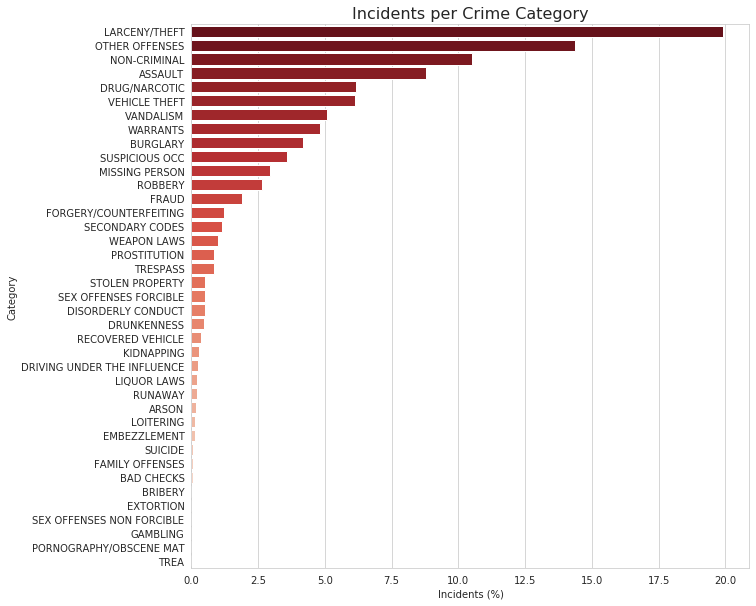

In [20]:
df_category = train_df.groupby(['Category'])['Dates'].count().sort_values(ascending=False)
plt.figure(figsize=(10, 10))
with sns.axes_style("whitegrid"):
    ax = sns.barplot(
        (df_category.values / df_category.values.sum()) * 100,
        df_category.index,
        orient='h',
        palette="Reds_r")

plt.title('Incidents per Crime Category', fontdict={'fontsize': 16})
plt.xlabel('Incidents (%)')

plt.show()

There are 39 categories of crimes. LARCENY/THEFT is most common, it's about 20% of all crimes. OTHER OFFENSES is untypical category, because it isn't known what really had happened. NON-CRIMINAL is about 10,5% of all crimes and ASSAULT is ~9%. 

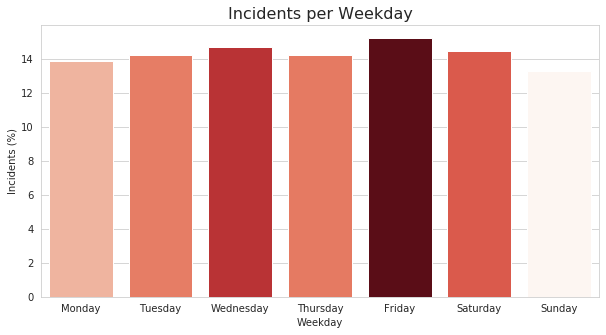

In [21]:
df_dayOfWeek = train_df.groupby(['DayOfWeek'])['Dates'].count()
df_dayOfWeek = df_dayOfWeek.reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
    'Sunday'
])
plt.figure(figsize=(10, 5))
with sns.axes_style("whitegrid"):
    ax = sns.barplot(
        df_dayOfWeek.index, (df_dayOfWeek.values / df_dayOfWeek.values.sum()) * 100,
        orient='v',
        palette=cm.ScalarMappable(cmap='Reds').to_rgba(df_dayOfWeek.values))

plt.title('Incidents per Weekday', fontdict={'fontsize': 16})
plt.xlabel('Weekday')
plt.ylabel('Incidents (%)')

plt.show()

In [22]:
train_df['Dates'] = pd.to_datetime(train_df['Dates'])
test_df['Dates'] = pd.to_datetime(test_df['Dates'])

In [23]:
array = train_df.groupby([train_df['Dates'].dt.date,train_df['DayOfWeek']])['X'].count().reset_index()
monday = array[array['DayOfWeek']=='Monday']['X'].array
tuesday = array[array['DayOfWeek']=='Tuesday']['X'].array
wednesday = array[array['DayOfWeek']=='Wednesday']['X'].array
thursday = array[array['DayOfWeek']=='Thursday']['X'].array
friday = array[array['DayOfWeek']=='Friday']['X'].array
saturday = array[array['DayOfWeek']=='Saturday']['X'].array
sunday = array[array['DayOfWeek']=='Sunday']['X'].array

In [62]:
def testn(arg,num):
        
        l = np.array(arg)
        alfa = 0.05
        m, s = sp.stats.norm.fit(l)
               
        print('\033[95mKurtosis\033[0m for the tested variable is equal to: %s while \033[95mslant\033[0m is equal: %s\n'% (round(sp.stats.kurtosis(l),2),round(sp.stats.skew(l),2)))
        
        test = sm.stats.diagnostic.lilliefors(l, dist='norm', pvalmethod= 'table')

        print('For the tested variable, the value of the test statistic for the \033[91mLilliefors\033[0m test equals: %s while p-value: %s'%(round(test[0],4),round(test[1],4)))
        
        if round(test[1],4) <= alfa/num:
                print('Based on the test performed \033[92mwe reject\033[0m the hypothesis about the normality of the distribution of the studied variable.\n')
        else:
                print('There is no reason to reject the hypothesis of the normality of the distribution of the studied variable.\n')

In [25]:
testn(monday,3)
testn(tuesday,3)
testn(wednesday,3)
testn(thursday,3)
testn(friday,3)
testn(saturday,3)
testn(sunday,3)

Kurtosis for the tested variable is equal to: 1.3 while slant is equal: -0.05

For the tested variable, the value of the test statistic for the Lilliefors test equals: 0.0332 while p-value: 0.2
There is no reason to reject the hypothesis of the normality of the distribution of the studied variable.

Kurtosis for the tested variable is equal to: 2.08 while slant is equal: -0.36

For the tested variable, the value of the test statistic for the Lilliefors test equals: 0.0558 while p-value: 0.0571
There is no reason to reject the hypothesis of the normality of the distribution of the studied variable.

Kurtosis for the tested variable is equal to: 2.71 while slant is equal: -0.38

For the tested variable, the value of the test statistic for the Lilliefors test equals: 0.0452 while p-value: 0.2
There is no reason to reject the hypothesis of the normality of the distribution of the studied variable.

Kurtosis for the tested variable is equal to: 1.43 while slant is equal: -0.42

For the test

In [26]:
mondayn = sp.stats.boxcox(monday, lmbda=None, alpha=None)
tuesdayn = sp.stats.boxcox(tuesday, lmbda=None, alpha=None)
wednesdayn = sp.stats.boxcox(wednesday, lmbda=None, alpha=None)
thursdayn = sp.stats.boxcox(thursday, lmbda=None, alpha=None)
fridayn = sp.stats.boxcox(friday, lmbda=None, alpha=None)
saturdayn = sp.stats.boxcox(saturday, lmbda=None, alpha=None)
sundayn = sp.stats.boxcox(sunday, lmbda=None, alpha=None)

In [27]:
testn(mondayn[0],3)
testn(tuesdayn[0],3)
testn(wednesdayn[0],3)
testn(thursdayn[0],3)
testn(fridayn[0],3)
testn(saturdayn[0],3)
testn(sundayn[0],3)

Kurtosis for the tested variable is equal to: 1.2 while slant is equal: 0.06

For the tested variable, the value of the test statistic for the Lilliefors test equals: 0.0334 while p-value: 0.2
There is no reason to reject the hypothesis of the normality of the distribution of the studied variable.

Kurtosis for the tested variable is equal to: 1.12 while slant is equal: 0.09

For the tested variable, the value of the test statistic for the Lilliefors test equals: 0.0602 while p-value: 0.0336
There is no reason to reject the hypothesis of the normality of the distribution of the studied variable.

Kurtosis for the tested variable is equal to: 1.15 while slant is equal: 0.11

For the tested variable, the value of the test statistic for the Lilliefors test equals: 0.048 while p-value: 0.1717
There is no reason to reject the hypothesis of the normality of the distribution of the studied variable.

Kurtosis for the tested variable is equal to: 1.21 while slant is equal: 0.08

For the tested

In [28]:
if round(sp.stats.levene(monday,tuesday,wednesday,thursday,friday,saturday,sunday,center = 'median')[1],4) <= 0.05/3:
        print('Based on test performed \033[92mwe reject\033[0m hypothesis of homogeneity of variance in the studied groups.\n')
else:
        print('There is no reason to reject the hypothesis of homogeneity of variance in the studied groups.\n')

There is no reason to reject the hypothesis of homogeneity of variance in the studied groups.



Null hypothesis:
-  the population median of all of the groups are equal

Alternative hypothesis:
- at least two groups are different

In [29]:
if round(sp.stats.kruskal(monday,tuesday,wednesday,thursday,friday,saturday,sunday)[1],4) <= 0.05/3:
            print('Based on test performed \033[92mwe reject\033[0m hypothesis of equality of medians in the studied groups.\n')
else:
        print('There is no reason to reject the hypothesis of homogeneity of equality of medians in the studied groups.\n')

Based on test performed we reject hypothesis of equality of medians in the studied groups.



In [30]:
round(sps.posthoc_dunn([monday,tuesday,wednesday,thursday,friday,saturday,sunday]),4)

,1,2,3,4,5,6,7
1,-1.0000,0.0033,0.0000,0.0002,0.0000,0.0000,0.0
2,0.0033,-1.0000,0.0000,0.4130,0.0000,0.1362,0.0
3,0.0000,0.0000,-1.0000,0.0011,0.0003,0.0097,0.0
4,0.0002,0.4130,0.0011,-1.0000,0.0000,0.5023,0.0
5,0.0000,0.0000,0.0003,0.0000,-1.0000,0.0000,0.0
6,0.0000,0.1362,0.0097,0.5023,0.0000,-1.0000,0.0
7,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-1.0


Based on statistic tests, we can see that:
- **Tuesday - Thursday - Saturday** satisfy null hypothesis

- other days are statistically different.

But we do not expect this variable to play a significant role in the prediction.

### Extract part of day from *Dates* column

- 02:00-06:00 is **Dawn**
- 06:00-10:00 is **Morning**
- 10:00-14:00 is **Noon**
- 14:00-18:00 is **After noon**
- 18:00-22:00 is **Evening**
- 22:00-02:00 is **Night**

#### Define function which tells which part of the day is it

In [31]:
hour_2 = pd.to_datetime('2:00:00').time()
hour_6 = pd.to_datetime('6:00:00').time()
hour_10 = pd.to_datetime('10:00:00').time()
hour_14 = pd.to_datetime('14:00:00').time()
hour_18 = pd.to_datetime('18:00:00').time()
hour_22 = pd.to_datetime('22:00:00').time()
def get_part_of_day(time):
    return (
        "Dawn" if hour_2 <= time < hour_6
        else
        "Morning" if hour_6 <= time < hour_10
        else
        "Noon" if hour_10 <= time < hour_14
        else
        "After Noon" if hour_14 <= time < hour_18
        else
        "Evening" if hour_18 <= time < hour_22
        else 
        "Night"
    )

In [32]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 875726 entries, 0 to 878048
Data columns (total 9 columns):
Dates         875726 non-null datetime64[ns]
Category      875726 non-null object
Descript      875726 non-null object
DayOfWeek     875726 non-null object
PdDistrict    875726 non-null object
Resolution    875726 non-null object
Address       875726 non-null object
X             875726 non-null float64
Y             875726 non-null float64
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 66.8+ MB


In [33]:
train_df['PartOfDay'] = train_df['Dates'].dt.time.apply(get_part_of_day)
test_df['PartOfDay'] = test_df['Dates'].dt.time.apply(get_part_of_day)

In [34]:
train_df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,PartOfDay
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,Night
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,Night
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,Night
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,Night
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,Night


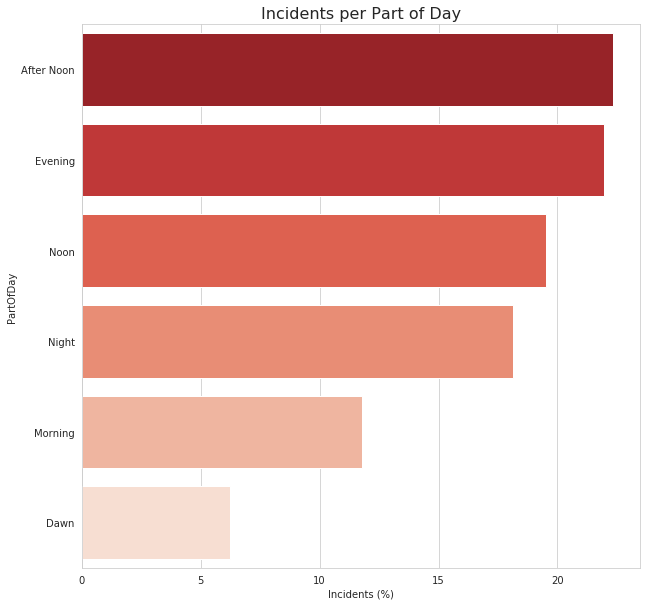

In [35]:
df_partOfDay = train_df.groupby(['PartOfDay'])['Dates'].count().sort_values(ascending=False)
# df_partOfDay.plot(kind='barh',figsize=(15,7))
plt.figure(figsize=(10, 10))
with sns.axes_style("whitegrid"):
    ax = sns.barplot(
        (df_partOfDay.values / df_partOfDay.values.sum()) * 100,
        df_partOfDay.index,
        orient='h',
        palette="Reds_r")

plt.title('Incidents per Part of Day', fontdict={'fontsize': 16})
plt.xlabel('Incidents (%)')

plt.show()

More than 45% incidents happened between 14:00-22:00 (After Noon - Evening). The fewest incidents were in the Morning and Dawn, because in this time, people usually are in their houses.

In [36]:
train_df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,PartOfDay
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,Night
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,Night
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,Night
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,Night
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,Night


### Multiple crimes or group crime?

As we can see above, crimes 0 and 1 occured at the same time in the same location. Group crime or multiple crimes?

1     551833
2      96936
3      33855
4       4195
5       1355
6        434
7        159
8         69
9         38
10        13
11         9
12         4
13         1
dtype: int64

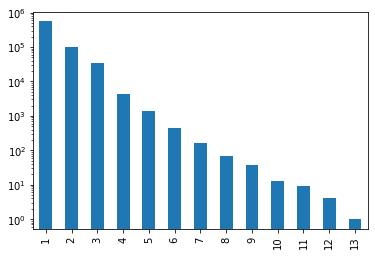

In [37]:
df_multiple_crimes = train_df.groupby(['Dates','X','Y']).size()
df_multiple_crimes_test = test_df.groupby(['Dates','X','Y']).size()
df_multiple_crimes.value_counts().plot('bar', logy=True)
df_multiple_crimes.value_counts()

As we can see it occurs not so rarely. There are about 300,000 multiply or group crimes.

In [38]:
other = pd.DataFrame(df_multiple_crimes)
other = other.reset_index()
train_df = train_df.merge(other, how='right')

In [39]:
other_test = pd.DataFrame(df_multiple_crimes_test)
other_test = other_test.reset_index()
test_df = test_df.merge(other_test, how='right')

In [40]:
train_df[train_df[0]==13]

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,PartOfDay,0
20289,2015-02-04 23:21:00,WEAPON LAWS,TAMPERING WITH MARKS ON FIREARM,Wednesday,MISSION,"ARREST, BOOKED",FOLSOM ST / 22ND ST,-122.414389,37.7557,Night,13
20290,2015-02-04 23:21:00,DRUG/NARCOTIC,POSSESSION OF MARIJUANA,Wednesday,MISSION,"ARREST, BOOKED",FOLSOM ST / 22ND ST,-122.414389,37.7557,Night,13
20291,2015-02-04 23:21:00,WEAPON LAWS,"FIREARM, LOADED, IN VEHICLE, POSSESSION OR USE",Wednesday,MISSION,"ARREST, BOOKED",FOLSOM ST / 22ND ST,-122.414389,37.7557,Night,13
20292,2015-02-04 23:21:00,WEAPON LAWS,"AMMUNITION, POSS. BY PROHIBITED PERSON",Wednesday,MISSION,"ARREST, BOOKED",FOLSOM ST / 22ND ST,-122.414389,37.7557,Night,13
20293,2015-02-04 23:21:00,WEAPON LAWS,FIREARM POSSESSION IN SCHOOL ZONE,Wednesday,MISSION,"ARREST, BOOKED",FOLSOM ST / 22ND ST,-122.414389,37.7557,Night,13
20294,2015-02-04 23:21:00,WEAPON LAWS,VIOLATION OF RESTRICTIONS ON A FIREARM TRANSFER,Wednesday,MISSION,"ARREST, BOOKED",FOLSOM ST / 22ND ST,-122.414389,37.7557,Night,13
20295,2015-02-04 23:21:00,WEAPON LAWS,POSS OF LOADED FIREARM,Wednesday,MISSION,"ARREST, BOOKED",FOLSOM ST / 22ND ST,-122.414389,37.7557,Night,13
20296,2015-02-04 23:21:00,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Wednesday,MISSION,"ARREST, BOOKED",FOLSOM ST / 22ND ST,-122.414389,37.7557,Night,13
20297,2015-02-04 23:21:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,MISSION,"ARREST, BOOKED",FOLSOM ST / 22ND ST,-122.414389,37.7557,Night,13
20298,2015-02-04 23:21:00,OTHER OFFENSES,RESISTING ARREST,Wednesday,MISSION,"ARREST, BOOKED",FOLSOM ST / 22ND ST,-122.414389,37.7557,Night,13


13 crimes at the same time in the same place ? 

### Which District is the most dangerous

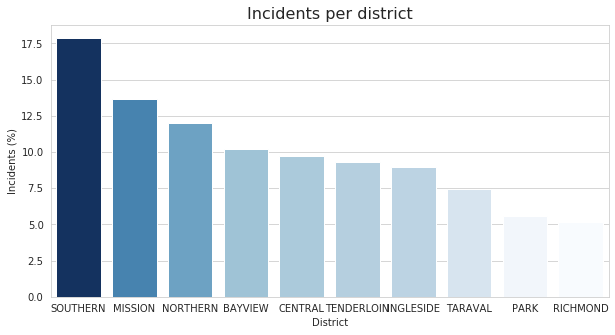

In [41]:
df_district = train_df.groupby(['PdDistrict'])['Dates'].count().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
with sns.axes_style("whitegrid"):
    ax = sns.barplot(
        df_district.index, (df_district.values / df_district.values.sum()) * 100,
        orient='v',
        palette=cm.ScalarMappable(cmap='Blues').to_rgba(df_district.values))

plt.title('Incidents per district', fontdict={'fontsize': 16})
plt.xlabel('District')
plt.ylabel('Incidents (%)')

plt.show()

SOUTHERN is the most dangerous police district. There were about 17.5 % incidents.   

Let's visualize it!

In [42]:
crime_district_count = pd.DataFrame(train_df.groupby(['PdDistrict'])['Dates'].count())
crime_district_count.reset_index(inplace=True)

In [43]:
latitude = 37.77
longitude = -122.42
sf_districts = f'data/sfpddistricts.geojson'

sf_map = folium.Map(
       location=[latitude,longitude],
       zoom_start=12)

sf_map.choropleth(
        geo_data=sf_districts,
        data=crime_district_count,
        columns=['PdDistrict','Dates'],
        key_on='feature.properties.DISTRICT',
        fill_color='YlOrRd',
        fill_opacity='0.7',
        line_opacity='0.2',
        legend_name='Crime Rate in San Francisco, by District')

sf_map

### How did number of crimes look each year

In [44]:
train_df['Year'] = train_df['Dates'].apply(lambda x : '{year}'.format(year=x.year))

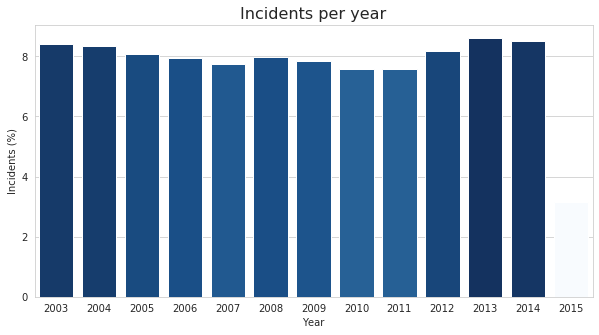

In [45]:
df_year = train_df.groupby('Year')['Dates'].count()
plt.figure(figsize=(10, 5))
with sns.axes_style("whitegrid"):
    ax = sns.barplot(
        df_year.index, (df_year.values / df_year.values.sum()) * 100,
        orient='v',
        palette=cm.ScalarMappable(cmap='Blues').to_rgba(df_year.values))

plt.title('Incidents per year', fontdict={'fontsize': 16})
plt.xlabel('Year')
plt.ylabel('Incidents (%)')

plt.show()

Each year number of crimes was similar. 2015 is different, because of data ranges 1/1/2013 to 5/13/2015

### Data Preprocessing

- 2323 duplicate values and 67 rows with wrong latitues were removed earlier
- 'year' and 'PartOfDay' features were extracted

In [46]:
train_df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,PartOfDay,0,Year
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,Night,2,2015
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,Night,2,2015
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,Night,1,2015
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,Night,1,2015
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,Night,1,2015


#### Extracting another features

- Month,Day,Hour and Minute from 'Dates' field
- if crime has taken place on a building block or not

In [47]:
def extract_feature(dataFrame):
    dataFrame['Month'] = dataFrame['Dates'].dt.month
    dataFrame['Day'] = dataFrame['Dates'].dt.day
    dataFrame['Hour'] = dataFrame['Dates'].dt.hour
    dataFrame['Minute'] = dataFrame['Dates'].dt.minute
    dataFrame['Block'] = dataFrame['Address'].str.contains('block', case=False)
    
    dataFrame.drop(columns=['Dates','Address',0], inplace=True)
    return dataFrame

In [48]:
train_df = extract_feature(train_df)
train_df.drop(columns=['Descript','Resolution'], inplace=True)
test_df = extract_feature(test_df)

In [49]:
train_df.head()

,Category,DayOfWeek,PdDistrict,X,Y,PartOfDay,Year,Month,Day,Hour,Minute,Block
0,WARRANTS,Wednesday,NORTHERN,-122.425892,37.774599,Night,2015,5,13,23,53,False
1,OTHER OFFENSES,Wednesday,NORTHERN,-122.425892,37.774599,Night,2015,5,13,23,53,False
2,OTHER OFFENSES,Wednesday,NORTHERN,-122.424363,37.800414,Night,2015,5,13,23,33,False
3,LARCENY/THEFT,Wednesday,NORTHERN,-122.426995,37.800873,Night,2015,5,13,23,30,True
4,LARCENY/THEFT,Wednesday,PARK,-122.438738,37.771541,Night,2015,5,13,23,30,True


#### Feature scaling

We ended up with 12 features. We will use label encoder to change string features to numerical.

In [50]:
test_df.head()

,Id,DayOfWeek,PdDistrict,X,Y,PartOfDay,Month,Day,Hour,Minute,Block
0,0,Sunday,BAYVIEW,-122.399588,37.735051,Night,5,10,23,59,True
1,1,Sunday,BAYVIEW,-122.391523,37.732432,Night,5,10,23,51,False
2,2,Sunday,NORTHERN,-122.426002,37.792212,Night,5,10,23,50,True
3,3,Sunday,INGLESIDE,-122.437394,37.721412,Night,5,10,23,45,True
4,4,Sunday,INGLESIDE,-122.437394,37.721412,Night,5,10,23,45,True


In [51]:
le1 = LabelEncoder()
train_df['PdDistrict'] = le1.fit_transform(train_df['PdDistrict'])
test_df['PdDistrict'] = le1.transform(test_df['PdDistrict'])

le2 = LabelEncoder()
train_df['DayOfWeek'] = le2.fit_transform(train_df['DayOfWeek'])
test_df['DayOfWeek'] = le2.transform(test_df['DayOfWeek'])

le3 = LabelEncoder()
train_df['PartOfDay'] = le3.fit_transform(train_df['PartOfDay'])
test_df['PartOfDay'] = le3.transform(test_df['PartOfDay'])

le4 = LabelEncoder()
train_df['Block'] = le4.fit_transform(train_df['Block'])
test_df['Block'] = le4.transform(test_df['Block'])

le5  = LabelEncoder()
y = le5.fit_transform(train_df.pop('Category'))

X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.3, stratify=y)

In [52]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [53]:
train_df.head()

,DayOfWeek,PdDistrict,X,Y,PartOfDay,Year,Month,Day,Hour,Minute,Block
0,6,4,-122.425892,37.774599,4,2015,5,13,23,53,0
1,6,4,-122.425892,37.774599,4,2015,5,13,23,53,0
2,6,4,-122.424363,37.800414,4,2015,5,13,23,33,0
3,6,4,-122.426995,37.800873,4,2015,5,13,23,30,1
4,6,5,-122.438738,37.771541,4,2015,5,13,23,30,1


# Modeling

### PCA - Principal Component Analysis

In [58]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)

evr = np.round(pca.explained_variance_ratio_,2)
print('Coefficients of explained variance for individual components:\n%s' % evr)

Coefficients of explained variance for individual components:
[0.12 0.11 0.11 0.1  0.09 0.09 0.09 0.09 0.08 0.07 0.04]


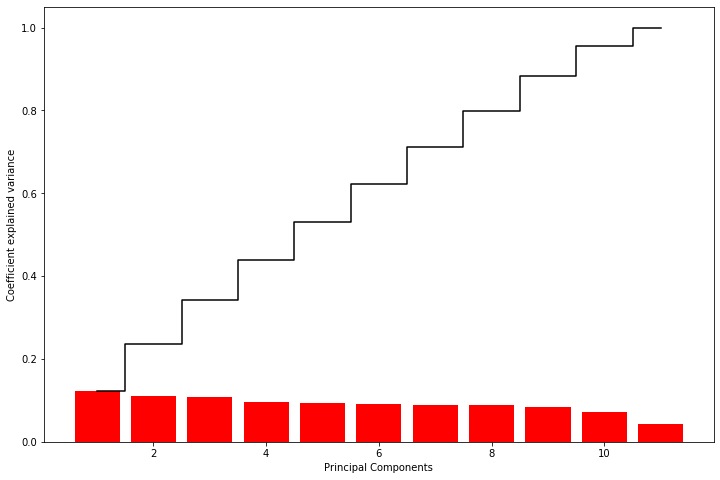

In [60]:
plt.figure(figsize = (12,8))
plt.bar(range(1, 12), pca.explained_variance_ratio_, align = 'center', color = 'red')
plt.step(range(1, 12), np.cumsum(pca.explained_variance_ratio_), where = 'mid', color = 'black')
plt.ylabel('Coefficient explained variance')
plt.xlabel('Principal Components')

plt.show()

We can see that each component has similar explained variance. PCA tried to put maximum possible information in the first component, then maximum remaining information in the second and so on. As we can see, we can't reduce dimensionality without losing much information, because each Component represents similar information.

### kNN - K-nearest neighbors 

We will find best k value by looping over range of values 1-50 and choose one.

In [ ]:
logloss = []
accuracyscore = []
for i in range(1, 50, 1):
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    knn.fit(X_train_std, y_train)
    y_pred = knn.predict(X_test_std)
#     logloss.append(log_loss(y_test, y_pred))
    accuracyscore.append(accuracy_score(y_test, y_pred))
plt.plot(accuracyscore)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=45, n_jobs=-1)
knn.fit(train_std, y_train)
y_pred = knn.predict(X_test_std)
print(accuracy_score(y_test, y_pred))

### Logistic Regression

In [83]:
lr = LogisticRegression().fit(X_train_std, y_train)
y_pred = lr.predict(X_test_std)
print(accuracy_score(y_test, y_pred))

0.23200542026050747


### Random Forest Classifier

In [72]:
parameters = {'max_depth':np.arange(1,50)}
rfc = RandomForestClassifier()
clf = GridSearchCV(rfc, parameters)
clf.fit(X_train_std, y_train)
y_pred = clf.predict(X_test_std)
print(accuracy_score(y_test, y_pred))

0.3002801482958914


In [89]:
test_std = sc.transform(test_df)
y_test_pred = clf.predict_proba(test_std)
sub=pd.read_csv('data/sampleSubmission.csv')
sub.shape
y_test_pred.shape
sub.iloc[:,1:] = y_test_pred.round(4)
sub.head()
sub.to_csv('submission.csv',index=False)

In [87]:
clf.best_params_

{'max_depth': 16}

### SVM - Support Vector Machines

In [ ]:
svm = SVC(kernel = 'rbf', random_state = 1, C = 1.0)
svm.fit(X_train_std, y_train)